In [ ]:
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
dataset = load_dataset("y", split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/6 [00:00<?, ? examples/s]

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch


In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", device_map="auto", load_in_8bit=True)

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/7.05k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/995M [00:00<?, ?B/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/999M [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/985M [00:00<?, ?B/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/782M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Next we define our `LoraConfig` object. We explicitly tell

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

In [ ]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=3, collate_fn=collate_fn)

In [ ]:
import torch

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device = "cuda" if torch.cuda.is_available() else "cpu"

model.train()

for epoch in range(10):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device, torch.float16)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0
Loss: 5.390625
Loss: 4.7265625
Epoch: 1
Loss: 4.62890625
Loss: 3.548828125
Epoch: 2
Loss: 4.38671875
Loss: 4.52734375
Epoch: 3
Loss: 3.505859375
Loss: 4.0859375
Epoch: 4
Loss: 3.1953125
Loss: 3.197265625
Epoch: 5
Loss: 1.40234375
Loss: 2.26953125
Epoch: 6
Loss: 2.376953125
Loss: 2.05078125
Epoch: 7
Loss: 1.4130859375
Loss: 1.3623046875
Epoch: 8
Loss: 1.095703125
Loss: 1.0595703125
Epoch: 9
Loss: 0.994140625
Loss: 0.7705078125


## Inference

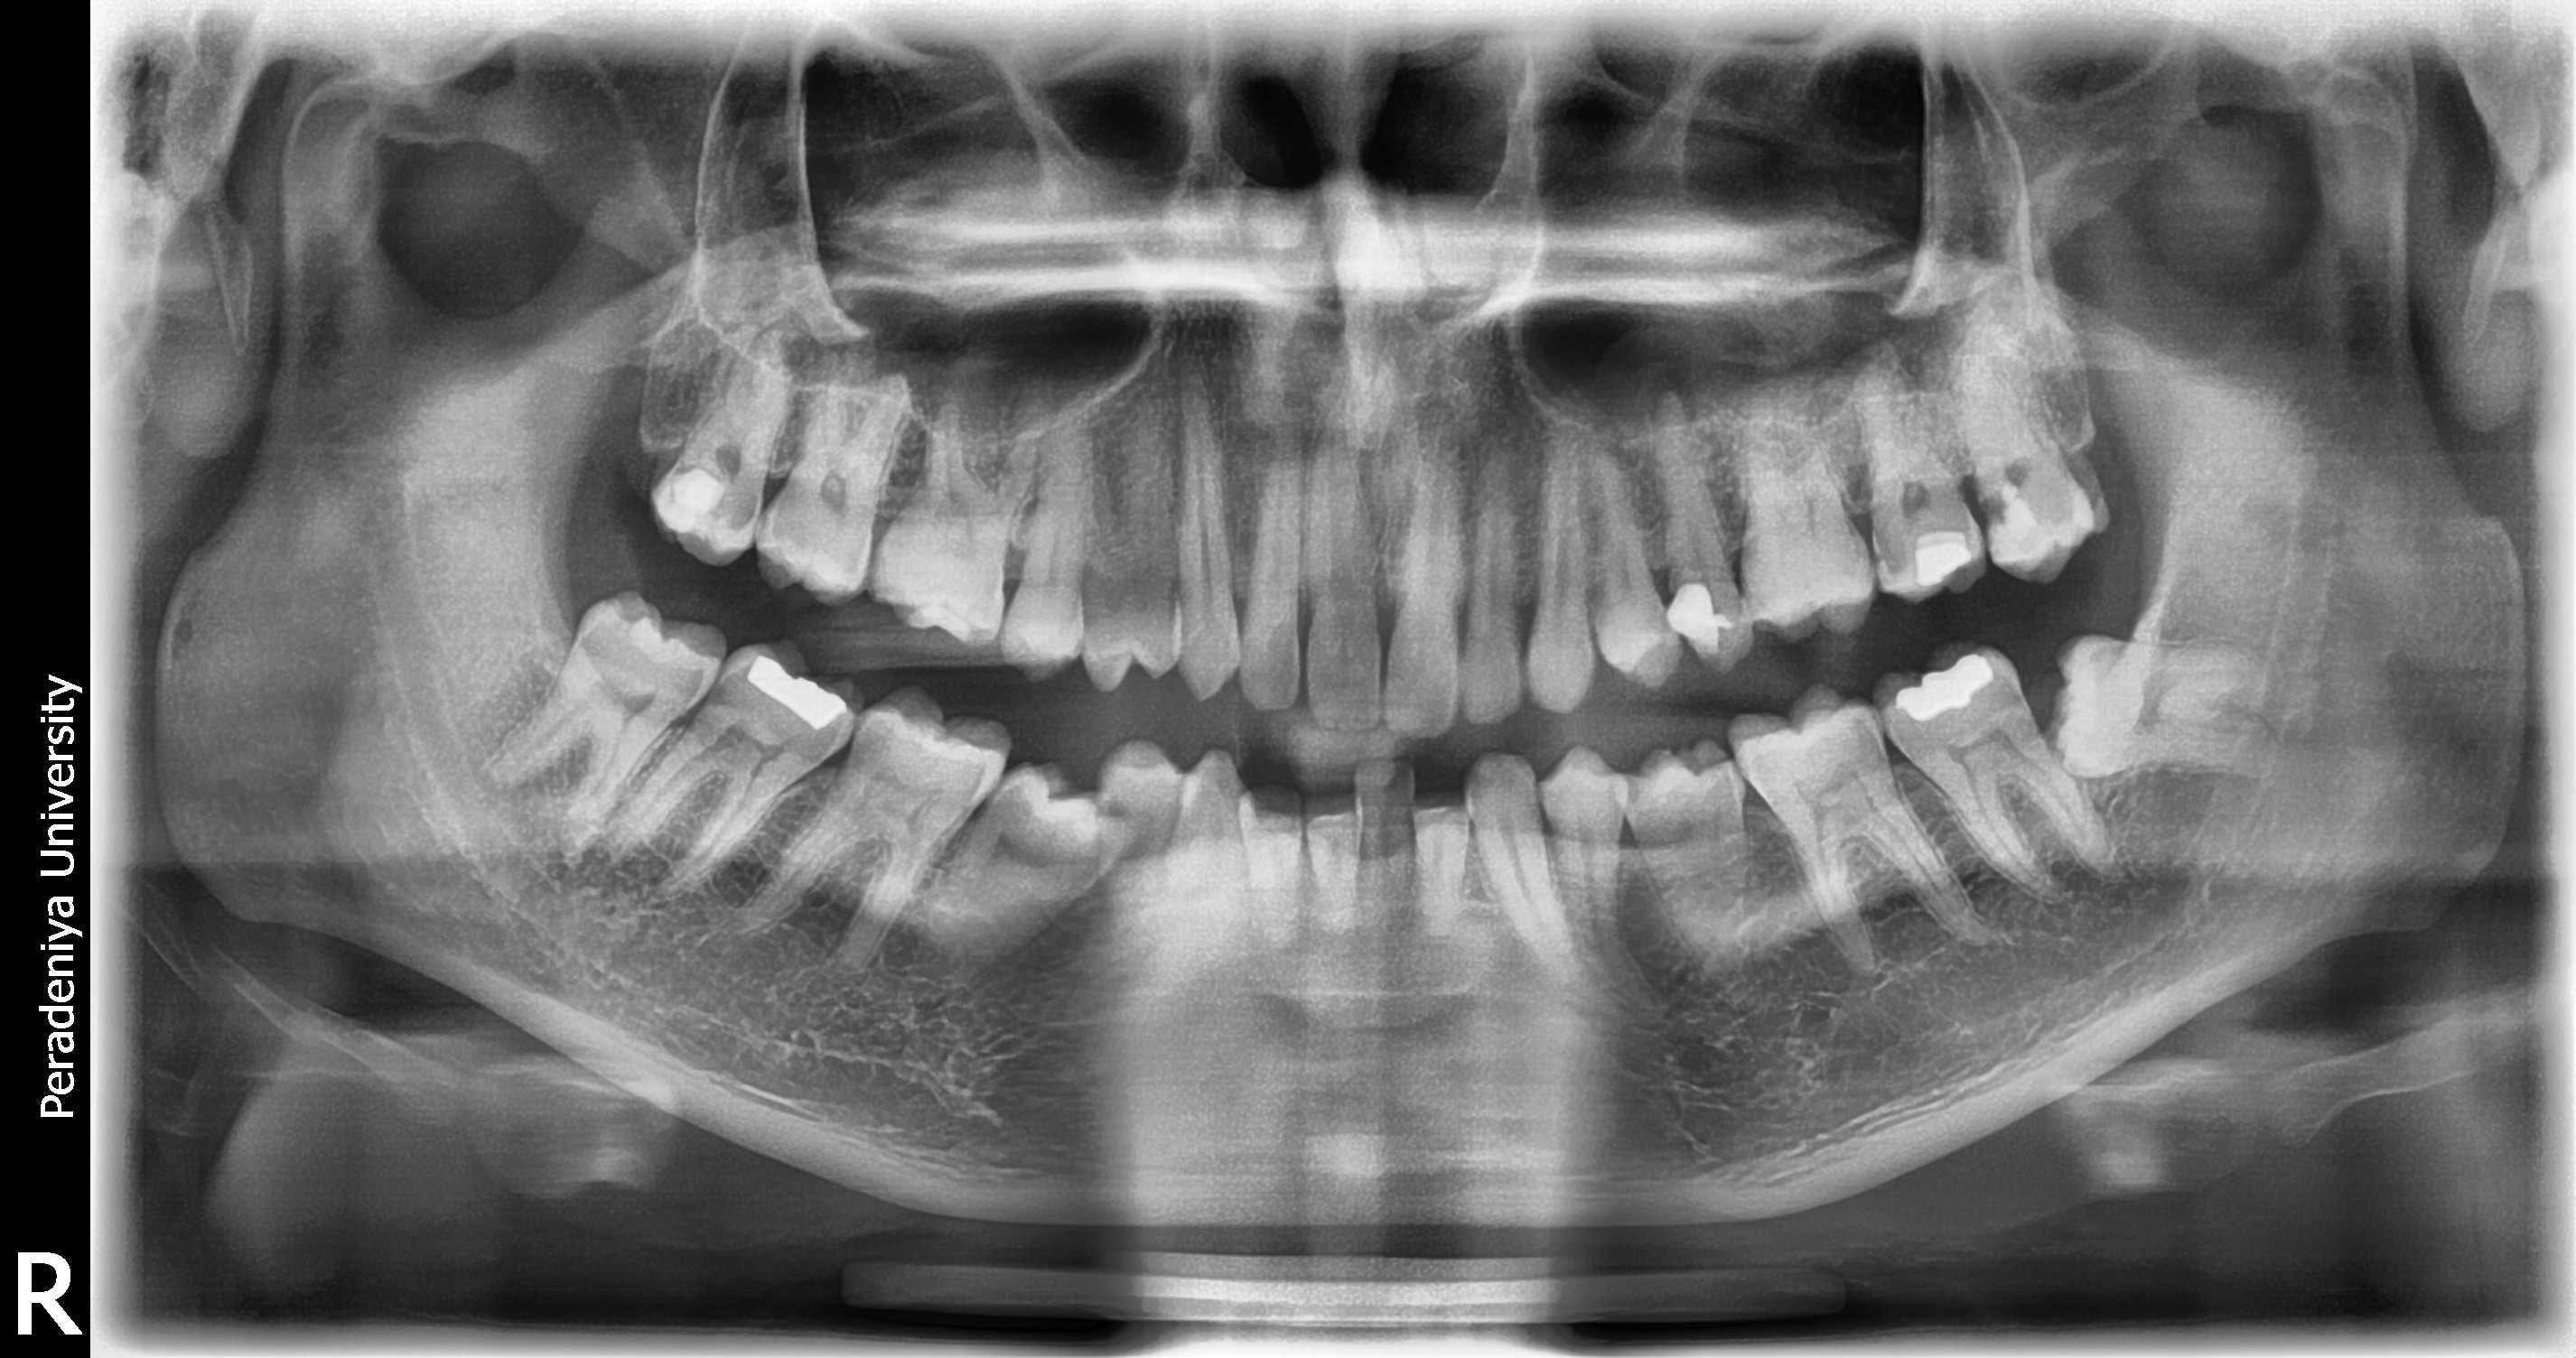

In [ ]:
# load image
example = dataset[0]
image = example["image"]
image

In [ ]:
from PIL import Image
image = Image.open('')

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

## Push to Hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
model = model.merge_and_unload()

In [ ]:
model.push_to_hub("")

In [ ]:
AutoProcessor.push_to_hub("")

In [ ]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration

processor = Blip2Processor.from_pretrained("")
model = Blip2ForConditionalGeneration.from_pretrained("")